#### remove-text-from-image

In order to erase text from images we will go through three steps:
이미지에서 텍스트를 지우기 위해선 다음과 같은 세 단계를 거쳐야합니다.

1.Identify text in the image and obtain the bounding box coordinates of each text, using Keras-ocr.
이미지내에서 텍스트를 인식한 후 각 텍스트에 boundging box 를 그려준다

2.For each bounding box, apply a mask to tell the algorithm which part of the image we should inpaint.
각각 bounding box 에 대해 mask 를 적용합니다. 이 mask를 통해 추후 inpaint 작업시 
어느 곳에 inpaint를 수행해야 할 지 알고리즘이 알 수 있게 합니다.

3.Finally, apply an inpainting algorithm to inpaint the masked areas of the image, resulting in a text-free image, using cv2.
마지막으로, inpainting algorithm을 이용하여 이미지내 masking 한 영역에 inpaint작업을 수행 후 text 가 제거된 이미지를 도출합니다.

참고 사이트: https://towardsdatascience.com/remove-text-from-images-using-cv2-and-keras-ocr-24e7612ae4f4

# 1. Obtain the bounding box & coordinates

In [278]:
import easyocr
import cv2
import os
import numpy as np
image_path ='C:\\Users\\HP\\Desktop\\mtvs-ai\\8월\\8월12일'
image_src = 'meme1.png'
full_path = os.path.join(image_path, image_src)

# 한글 경로 인식
img_array = np.fromfile(full_path, np.uint8)
img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)



In [175]:
reader = easyocr.Reader(['en'])

In [234]:
readtext_result = reader.readtext(img, min_size = 5)

In [261]:
box_list=[]
box_list.extend(row[0] for row in readtext_result)

In [262]:
box_list

[[[73, 7], [135, 7], [135, 21], [73, 21]],
 [[56, 47], [147, 47], [147, 85], [56, 85]],
 [[58, 72], [144, 72], [144, 100], [58, 100]],
 [[60, 100], [112, 100], [112, 108], [60, 108]],
 [[26, 122], [68, 122], [68, 130], [26, 130]],
 [[72, 122], [96, 122], [96, 128], [72, 128]],
 [[106, 120], [142, 120], [142, 128], [106, 128]],
 [[154, 118], [174, 118], [174, 126], [154, 126]],
 [[26, 132], [38, 132], [38, 140], [26, 140]],
 [[42, 132], [58, 132], [58, 140], [42, 140]],
 [[72, 132], [88, 132], [88, 138], [72, 138]],
 [[98, 130], [154, 130], [154, 136], [98, 136]],
 [[94, 160], [118, 160], [118, 166], [94, 166]],
 [[68, 170], [82, 170], [82, 176], [68, 176]],
 [[93, 167], [133, 167], [133, 179], [93, 179]],
 [[94, 178], [118, 178], [118, 186], [94, 186]],
 [[68, 190], [82, 190], [82, 196], [68, 196]],
 [[94, 188], [118, 188], [118, 196], [94, 196]],
 [[86, 198], [108, 198], [108, 204], [86, 204]],
 [[112, 196], [132, 196], [132, 204], [112, 204]],
 [[76, 208], [100, 208], [100, 214], [76

In [269]:
for box in box_list:
    print(box[0])

[73, 7]
[56, 47]
[58, 72]
[60, 100]
[26, 122]
[72, 122]
[106, 120]
[154, 118]
[26, 132]
[42, 132]
[72, 132]
[98, 130]
[94, 160]
[68, 170]
[93, 167]
[94, 178]
[68, 190]
[94, 188]
[86, 198]
[112, 196]
[76, 208]
[104, 208]
[52, 216]
[94, 216]
[80, 226]
[108, 226]
[72, 236]
[104, 236]
[56, 244]
[82, 244]
[108, 244]
[52, 254]
[94, 254]
[54, 264]
[54, 274]
[72, 274]
[104, 272]
[54, 284]
[106, 284]
[150, 282]


In [254]:
x

73

# 2. opencv  로 masking 만들기

In [204]:
import math
import numpy as np
def midpoint(x1, y1, x2, y2):
    x_mid = int((x1 + x2)/2)
    y_mid = int((y1 + y2)/2)
    return (x_mid, y_mid)
#example of a line mask for the word "OH YOU READ ONE BOOK"
box = readtext_result[2][0]
x0, y0 = box[0][0], box[0][1]
x1, y1 = box[2][0], box[2][1]
x2, y2 = box[1][0], box[1][1] 
x3, y3 = box[3][0], box[3][1] 
        
x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)
thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))

In [205]:
mask = np.zeros(img.shape[:2], dtype="uint8")
cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255, thickness)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

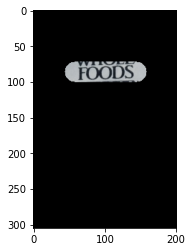

In [206]:
masked = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(masked)

# 3. inpainting 작업 수행

In [192]:
# b,g,r to r,g,b
def BGR2RGB(image):
    b,g,r = cv2.split(image)
    rgb_image = cv2.merge([r,g,b])
    return rgb_image

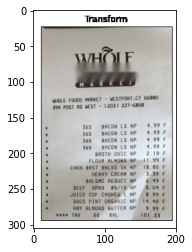

In [193]:
img_inpainted = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)
plt.imshow(BGR2RGB(img_inpainted))

# 위 내용 전부 함수화

In [348]:
import easyocr
import cv2
import os
import matplotlib.pyplot as plt
import math
import numpy as np

image_path ='C:\\Users\\HP\\Desktop\\mtvs-ai\\8월\\8월12일'
image_src = 'meme2.jpg'
full_path = os.path.join(image_path, image_src)

reader = easyocr.Reader(['en'])

def midpoint(x1, y1, x2, y2):
    x_mid = int((x1 + x2)/2)
    y_mid = int((y1 + y2)/2)
    return (x_mid, y_mid)

def inpaint_text(img_path):
    # read image
    img_array = np.fromfile(img_path, np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    
    # generate (word, box) tuples 
    readtext_result = reader.readtext(img, min_size = 7)
    mask = np.zeros(img.shape[:2], dtype="uint8")
    box_list=[]
    box_list.extend(row[0] for row in readtext_result)
    
    for box in box_list:
        x0, y0 = box[0]
        x1, y1 = box[2]
        x2, y2 = box[1]
        x3, y3 = box[3] 
        
        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)
        
        thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))
        
        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255,    
        thickness)
        img = cv2.inpaint(img, mask, 10, cv2.INPAINT_NS)
                 
    return(img)

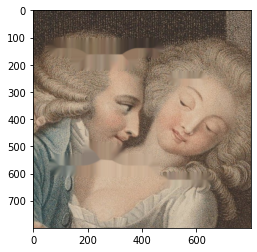

In [349]:

img_inpainted = inpaint_text(full_path)
plt.imshow(BGR2RGB(img_inpainted))